In [1]:
from __future__ import unicode_literals, print_function, division
import time
import random
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from utils import timeSince

In [2]:
device = torch.device("cpu")
from get_cn_en_pairs import get_training_pairs, SOS_token, EOS_token, MAX_LENGTH, output_lang, input_lang, tensorFromSentence

Reading lines...
Read 29371 sentence pairs
Trimmed to 2160 sentence pairs
Counting words...
Counted words:
cn 1209
en 1431
['我累死了 。', 'i m dead tired .']


In [87]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [89]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.GRU(hidden_size + hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size + hidden_size * 2, output_size)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden, context):
        embedded = self.dropout(self.embedding(input)).view(1, 1, -1)

        emb_con = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), dim = 1)
        output = self.softmax(self.out(output))
        return output, hidden

In [90]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

    decoder_input = torch.tensor([[SOS_token]], device=device)

    context = encoder_hidden
    decoder_hidden = encoder_hidden #

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, context)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, context)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [91]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    training_pairs = get_training_pairs(n_iters)

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [92]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, True)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        context = encoder_hidden
        decoder_hidden = encoder_hidden

        decoded_words = []
        # decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, context)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


In [93]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [94]:
hidden_size = 256
encoder1 = Encoder(input_lang.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)

train_losses = trainIters(encoder1, decoder1, 75000, print_every=5000)


2m 13s (- 31m 4s) (5000 6%) 3.1364
4m 27s (- 28m 59s) (10000 13%) 1.9768
6m 44s (- 26m 57s) (15000 20%) 1.2581
9m 5s (- 24m 59s) (20000 26%) 0.8732
11m 22s (- 22m 45s) (25000 33%) 0.6010
13m 44s (- 20m 37s) (30000 40%) 0.4422
16m 6s (- 18m 24s) (35000 46%) 0.3482
18m 26s (- 16m 8s) (40000 53%) 0.2951
20m 47s (- 13m 51s) (45000 60%) 0.2930
23m 37s (- 11m 48s) (50000 66%) 0.2743
25m 59s (- 9m 26s) (55000 73%) 0.2318
28m 18s (- 7m 4s) (60000 80%) 0.2532
30m 39s (- 4m 43s) (65000 86%) 0.2037
33m 0s (- 2m 21s) (70000 93%) 0.2257
44m 48s (- 0m 0s) (75000 100%) 0.2196


<Figure size 640x480 with 0 Axes>

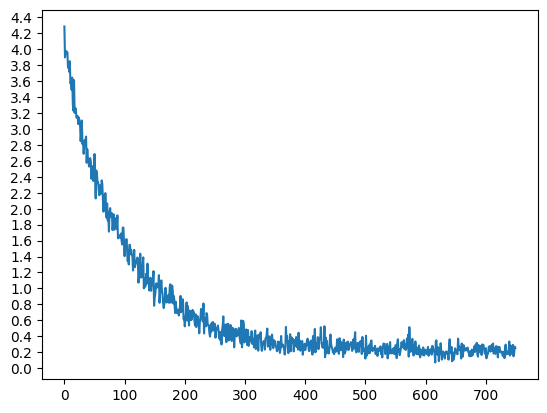

In [95]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

showPlot(train_losses)

In [96]:
evaluateRandomly(encoder1, decoder1)

> 他们是典型的年轻人 。
= they re typical youngsters .
< they re typical young people . <EOS>

> 我16岁了 。
= i am sixteen years old .
< i am sixteen years old . <EOS>

> 我要告诉汤姆 。
= i m going to go tell tom .
< i m going to go tell tom . <EOS>

> 认识您很高兴 。
= i m very happy to meet you .
< i m very happy to make your acquaintance . <EOS>

> 我怕我冒犯了你 。
= i m afraid i ve offended you .
< i m afraid i ve offended you . <EOS>

> 她是一个安静的女人 。
= she is a quiet woman .
< she is a quiet woman . <EOS>

> 你真坏 。
= you re so bad .
< you re terrible . . <EOS>

> 你也被邀请了 。
= you re invited too .
< you re invited too . <EOS>

> 我很清醒 。
= i m sober .
< i m sober . <EOS>

> 您可以做任何您想做的事 。
= you re welcome to do anything you like .
< you re welcome to do anything to you like . <EOS>



In [98]:
output_words = evaluate(encoder1, decoder1, '我是自由的')
output_sentence = ' '.join(output_words)
print(output_sentence)

i m free man . <EOS>


In [100]:
encoder_path = './models/seq2seq3-encoder.pt'
decoder_path = './models/seq2seq3-decoder.pt'
torch.save(encoder1.state_dict(), encoder_path)
torch.save(decoder1.state_dict(), decoder_path)